# Figures for manuscript

## Figure List
- Signal evolution: 
    - raw eeg -> smoothed power + artifact detection
    - raw dbs + artifact
    - aligned and synchronized signals (cut at artifact & resampled to lower frequency)

- Computation of correlation metrics and coherence

In [1]:
import sys
import os

# Get the path to the project root (one level up from the notebook)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root, NOT 'source', to sys.path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# print the sys.path
print(sys.path)

['/Users/lenasalzmann/dev/dbs-eeg-sync', '/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python312.zip', '/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python3.12', '/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python3.12/lib-dynload', '', '/Users/lenasalzmann/dev/dbs-eeg-sync/.venv/lib/python3.12/site-packages']


In [2]:
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import plotly.graph_objects as go
from source.data_loader import load_eeg_data, open_json_file, select_recording, read_time_domain_data
from source.sync_artefact_finder import detect_sync_from_eeg, find_dbs_peak
from source.power_calculater import compute_samplewise_eeg_power

In [3]:
sub_ids = [ 'P4-2001', 'P4-2002', 'P4-2003', 'P4-2004', 'P4-2005', 'P4-2007', 'P4-2008', 'P4-2009', 'P4-2010', 'P4-2011']
sub_id = 'P4-2002'
block = 'baseline'
dataDir_server = r"/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB"

In [4]:
file_info_dbs = [
    {"sub_id": "P4-2001", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2001/RawData/DBS/Report_Json_Session_Report_20240610T162159.json"},
    {"sub_id": "P4-2002", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2002/RawData/DBS/Report_Json_Session_Report_20240719T121230.json"},
    {"sub_id": "P4-2003", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2003/RawData/DBS/Report_Json_Session_Report_20241025T120701.json"},
    {"sub_id": "P4-2004", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2004/RawData/DBS/Report_Json_Session_Report_20241028T163753.json"},
    {"sub_id": "P4-2005", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2005/RawData/DBS/Report_Json_Session_Report_20241029T170455.json"},
    {"sub_id": "P4-2007", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2007/RawData/DBS/Report_Json_Session_Report_20250110T112532.json"},
    {"sub_id": "P4-2008", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2008/RawData/DBS/Report_Json_Session_Report_20250310T113259.json"},
    {"sub_id": "P4-2009", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2009/RawData/DBS/Report_Json_Session_Report_20250314T131338.json"},
    {"sub_id": "P4-2010", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2010/RawData/DBS/Report_Json_Session_Report_20250425T161748.json"},
    {"sub_id": "P4-2011", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2011/RawData/DBS/Report_Json_Session_Report_20250520T165018.json"},
    {"sub_id": "P4-2012", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2012/RawData/DBS/Report_Json_Session_Report_20250710T122046.json"},
]

Load Data 

In [5]:
# Load EEG data
eeg_file = os.path.join(dataDir_server, sub_id, 'ProcessedData', 'EEG', block, block + '_prep.set')
eeg_data, sfreq = load_eeg_data(eeg_file)

---
Successfully loaded /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2002/ProcessedData/EEG/baseline/baseline_prep.set


In [6]:
# Load DBS

# get file_path from file_info_dbs for sub_id = 'P4-2004'
if block == 'baseline':
    block_number = 0
# add block indexing later
dbs_path = [file for file in file_info_dbs if file['sub_id'] == sub_id][block_number]['file_path']

json_data = open_json_file(dbs_path)
dbs_data = read_time_domain_data(json_data, block_number) 

---
Successfully read DBS recording 0 with sampling frequency 250 Hz
...length of dbs signal in seconds: 159.252
...length of dbs signal in samples: 39813


### 0. Overview: Run Sync Detection

EEG data cropped to 120.0 seconds.


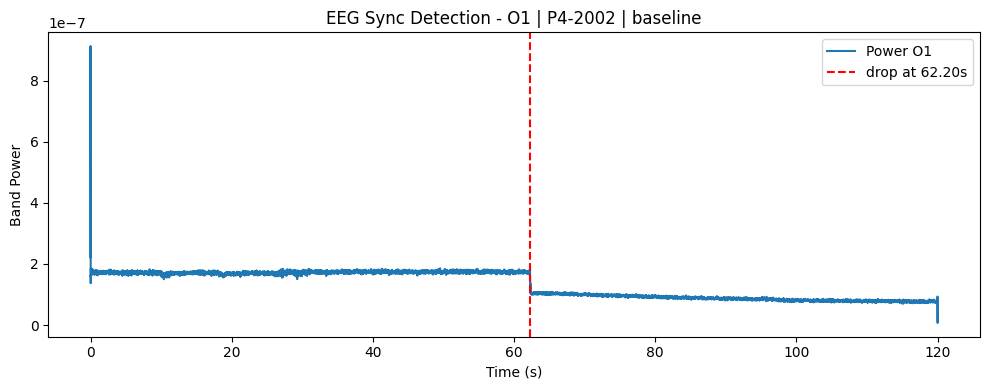

In [7]:
# EEG
if sub_id == 'P4-2007':
    channel, eeg_sync_idx, eeg_sync_s, result, smoothed_power = detect_sync_from_eeg(eeg_data, freq_low=110, freq_high=120, time_range=(0,120), plot=True, sub_id=sub_id, block=block)
else:
    channel, eeg_sync_idx, eeg_sync_s, result, smoothed_power = detect_sync_from_eeg(eeg_data, freq_low=120, freq_high=130, time_range=(0,120), plot=True, sub_id=sub_id, block=block)

# extract the smoothe_power samples around +- 0.5s around the artifact
eeg_power_artifact = smoothed_power[eeg_sync_idx-int(eeg_data.info['sfreq']/2):eeg_sync_idx+int(eeg_data.info['sfreq']/2)]
eeg_times = np.arange(len(eeg_power_artifact)) / eeg_data.info['sfreq']


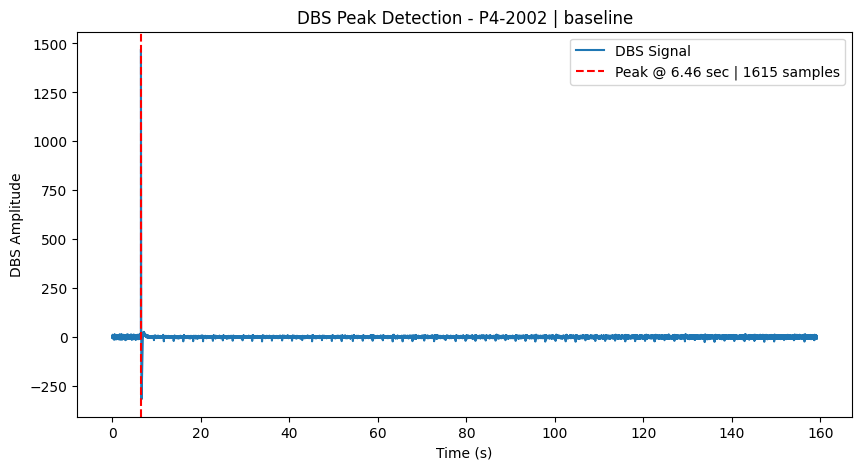

In [8]:
# Find DBS sync artifact
dbs_signal =  dbs_data["TimeDomainData"].values
dbs_fs = dbs_data["SampleRateInHz"][0]
dbs_peak_idx, dbs_peak_s = find_dbs_peak(dbs_signal, dbs_fs, save_dir=None, sub_id=sub_id, block=block)
# investigate the artifact
dbs_artifact = dbs_signal[dbs_peak_idx-int(dbs_fs/2):dbs_peak_idx+int(dbs_fs/2)]
dbs_times = np.arange(len(dbs_artifact)) / dbs_fs

In [9]:
# check the downsampling
eeg_sync_idx_downsampled = int(eeg_sync_idx/2000*250)
eeg_sync_idx_downsampled
print(eeg_sync_idx_downsampled/250)
print(eeg_sync_s)

62.196
62.196


### 1. Plot raw signals

EEG

In [10]:
# select the following channels from the eeg data

# eeg_data_ch_selected = eeg_data.copy().pick_channels(['Pz', 'Cz', 'Fz', 'POz', 'CPz'])
eeg_data_ch_selected = eeg_data.copy().pick_channels(['Cz', 'Fz', 'POz'])

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


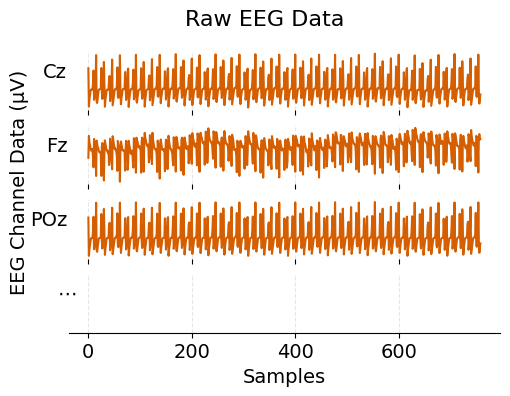

In [11]:
# extract the first 30 seconds of the eeg data for 5 channels

fs_eeg_org = int(eeg_data_ch_selected.info['sfreq'])
n_samples = int(0.38 * fs_eeg_org)

channel_data, times = eeg_data_ch_selected[:5, 1:n_samples]

eeg_sample_indices = np.arange(channel_data.shape[1])

n_channels = channel_data.shape[0]


fig, axes = plt.subplots(n_channels + 1, 1, figsize=(5, n_channels + 1), sharex=True)

# Plot EEG channels
for i in range(n_channels):
    ax = axes[i]
    # ax.plot(times, channel_data[i], color="#D55E00")  # time
    ax.plot(eeg_sample_indices, channel_data[i], color="#D55E00")  # sample indices
    ax.set_ylabel(eeg_data_ch_selected.ch_names[i], rotation=0, labelpad=1, fontsize=14, ha="right")
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    if i != n_channels:
        ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='x', labelsize=14)
    ax.grid(True, linestyle="--", alpha=0.3)

# Empty subplot
axes[-1].set_ylabel("⋯", rotation=0, labelpad=1, fontsize=14, ha="center")
axes[-1].set_yticks([])
axes[-1].spines['top'].set_visible(False)
axes[-1].spines['right'].set_visible(False)
axes[-1].spines['left'].set_visible(False)
axes[-1].spines['bottom'].set_visible(True)
axes[-1].tick_params(axis='x', labelsize=14)
axes[-1].grid(True, linestyle="--", alpha=0.3)  # optional grid

# Labels
# axes[-1].set_xlabel("Time (s)", fontsize=14)
axes[-1].set_xlabel("Samples", fontsize=14)
fig.suptitle("Raw EEG Data", fontsize=16)

plt.tight_layout()
fig.text(-0.01, 0.55, "EEG Channel Data (μV)", va='center', rotation='vertical', fontsize=14)  # Shared y-label

# save plot as pdf in outputs/plots
plt.savefig(f"outputs/plots/fig1_raw_eeg.pdf", bbox_inches='tight')

plt.show()

DBS

In [12]:
# select the whole dbs data

dbs_selected_data = dbs_data["TimeDomainData"].values

# cut first 2 seconds of dbs data
dbs_n_samples = int(3 * dbs_fs)
dbs_selected_data = dbs_data["TimeDomainData"].values[1:dbs_n_samples]  # first second of recording

# arrange dbs_times over the length of dbs_selected_data
dbs_times = np.linspace(0, (len(dbs_selected_data)/dbs_fs), len(dbs_selected_data))

dbs_sample_indices = np.arange(len(dbs_selected_data))

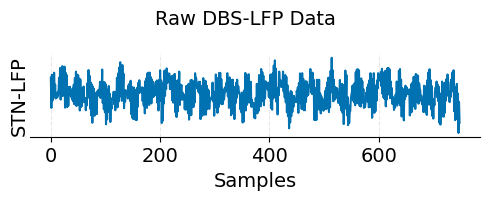

In [13]:
fig, ax = plt.subplots(figsize=(5, 2))

# ax.plot(dbs_times, dbs_selected_data, color="#0072B2")
ax.plot(dbs_sample_indices, dbs_selected_data, color="#0072B2")
ax.set_ylabel('STN-LFP', rotation=90, labelpad=1, fontsize=14, ha="center")

# Remove y-ticks
ax.set_yticks([])

# xticks fontsize 14
ax.tick_params(axis='x', labelsize=14)

# Hide all spines except bottom
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(True, linestyle="--", alpha=0.3)  # optional grid

# ax.set_xlabel("Time (s)")
ax.set_xlabel("Samples", fontsize=14)
fig.suptitle("Raw DBS-LFP Data", fontsize=14)

plt.tight_layout()

# save plot as pdf in outputs/plots
plt.savefig(f"outputs/plots/fig1_raw_dbs.pdf")
plt.show()


### 2. EEG Power Calculation

In [14]:
# Power for ['Pz', 'Cz', 'Fz', 'POz', 'CPz']

# _, _, _, _, power_Pz = detect_sync_from_eeg(eeg_data_ch_selected, freq_low=120, freq_high=130, channel_list=['Pz'], plot=False, save_dir=None, sub_id=sub_id, block=block)
_, _, _, _, power_Cz = detect_sync_from_eeg(eeg_data_ch_selected, freq_low=120, freq_high=130, channel_list=['Cz'], plot=False, save_dir=None, sub_id=sub_id, block=block)
_, _, _, _, power_Fz = detect_sync_from_eeg(eeg_data_ch_selected, freq_low=120, freq_high=130, channel_list=['Fz'], plot=False, save_dir=None, sub_id=sub_id, block=block)
best_channel, _, _, best_result,  power_POz = detect_sync_from_eeg(eeg_data_ch_selected, freq_low=120, freq_high=130, channel_list=['POz'], plot=False, save_dir=None, sub_id=sub_id, block=block)
# _, _, _, _, power_CPz = detect_sync_from_eeg(eeg_data_ch_selected, freq_low=120, freq_high=130, channel_list=['CPz'], plot=False, save_dir=None, sub_id=sub_id, block=block)

# power_all = [power_Pz, power_Cz, power_Fz, power_POz, power_CPz]

power_all = [power_Cz, power_Fz, power_POz]
power_time = best_result["power_time"]
power_samples_indices = np.arange(len(power_time))

EEG data cropped to 325.2 seconds.
EEG data cropped to 325.2 seconds.
EEG data cropped to 325.2 seconds.


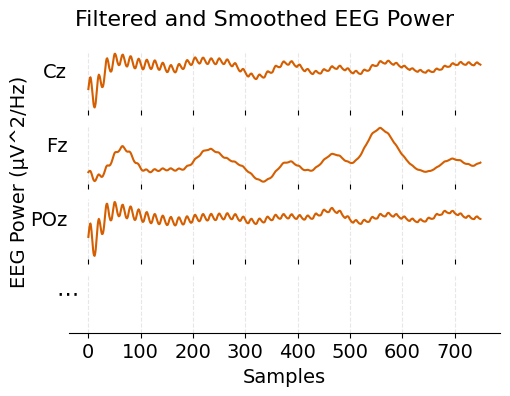

In [15]:
# plot the power for each channel

# Keep ~750 samples
power_all = np.array(power_all)  # Convert list to array
power_all_cut = power_all[:, 50:800]
power_samples_indices = np.arange(power_all_cut.shape[1])

# Get number of channels
n_channels = power_all_cut.shape[0]

# Plot with one extra empty subplot
fig, axes = plt.subplots(n_channels + 1, 1, figsize=(5, n_channels + 1), sharex=True)

for i in range(n_channels):
    ax = axes[i]
    ax.plot(power_samples_indices, power_all_cut[i], color="#D55E00")
    ax.set_ylabel(eeg_data_ch_selected.ch_names[i], rotation=0, labelpad=1, fontsize=14, ha="right")
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    if i != n_channels:
        ax.spines['bottom'].set_visible(False)
    ax.grid(True, linestyle="--", alpha=0.3)

# Add empty subplot
axes[-1].set_ylabel("⋯", rotation=0, labelpad=1, fontsize=16, ha="center")
axes[-1].set_yticks([])
axes[-1].spines['top'].set_visible(False)
axes[-1].spines['right'].set_visible(False)
axes[-1].spines['left'].set_visible(False)
axes[-1].spines['bottom'].set_visible(True)
axes[-1].grid(linestyle="--", alpha=0.3)

axes[-1].tick_params(axis='x', labelsize=14)
axes[-1].set_xlabel("Samples", fontsize=14)
fig.suptitle("Filtered and Smoothed EEG Power", fontsize=16)
plt.tight_layout()

# Shared y-label
fig.text(-0.01, 0.55, "EEG Power (μV^2/Hz)", va='center', rotation='vertical', fontsize=14)

# save plot as pdf in outputs/plots
plt.savefig(f"outputs/plots/fig1_eeg_power.pdf", bbox_inches='tight')
plt.show()


### 3. Artifact Selection

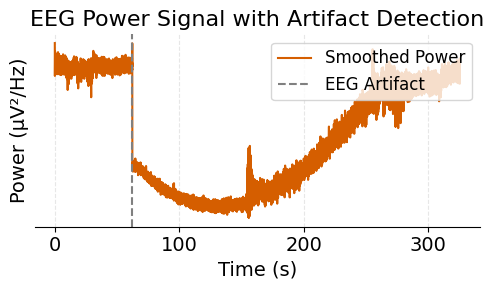

In [16]:
# plot eeg artifact with the sync artifact

best_smoothed = power_POz

# Create time vector based on sampling frequency and start time
eeg_time_vector = np.arange(len(best_smoothed)) / fs_eeg_org + 0
eeg_sample_indices = np.arange(len(best_smoothed))

#  cut the first 30 samples and last 30 samples
best_smoothed_cut = best_smoothed[100:-100]
time_vector_cut = eeg_time_vector[100:-100]
eeg_sample_indices_cut = eeg_sample_indices[100:-100]

sync_time = best_result["onset_time"]
sync_idx = best_result["onset_index"]

plt.figure(figsize=(5, 3))

# Plot line
plt.plot(time_vector_cut, best_smoothed_cut, label="Smoothed Power", color="#D55E00")
# plt.plot(eeg_sample_indices_cut, best_smoothed_cut, label="Smoothed Power", color="#D55E00")  # for samples

# Sync artifact
plt.axvline(sync_time, color="grey", linestyle="--", label=f"EEG Artifact")
# plt.axvline(sync_idx, color="grey", linestyle="--", label=f"EEG Artifact: {sync_idx} samples")

# Styling
plt.ylabel("Power (μV²/Hz)", fontsize=14)
plt.xlabel("Time (s)", fontsize=14)  # change to "Samples" if using index
plt.title(f"EEG Power Signal with Artifact Detection", fontsize=16)

# Hide spines except bottom
for spine in ['top', 'right', 'left']:
    plt.gca().spines[spine].set_visible(False)

# yticks empty
plt.yticks([])
# fontsize 14
plt.tick_params(axis='x', labelsize=14)

plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(fontsize=12, loc='upper right')


plt.tight_layout()
# save plot as pdf in outputs/plots
plt.savefig(f"outputs/plots/fig1_eeg_power_artifact.pdf")
plt.show()

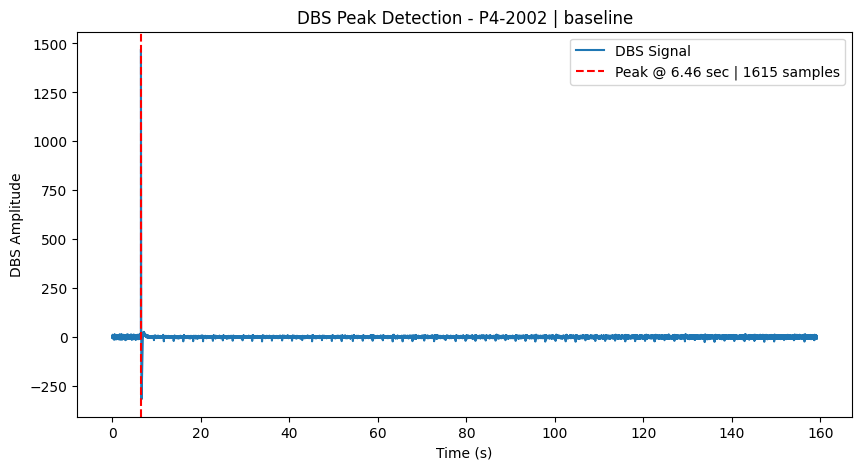

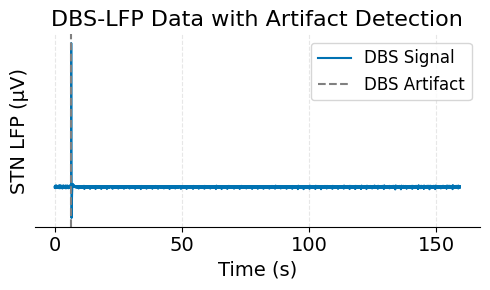

In [17]:
# Find DBS sync artifact
dbs_signal =  dbs_data["TimeDomainData"].values
dbs_fs = dbs_data["SampleRateInHz"][0]
dbs_peak_idx, dbs_peak_s = find_dbs_peak(dbs_signal, dbs_fs, save_dir=None, sub_id=sub_id, block=block)

# plot again in publication style
dbs_time_axis = np.arange(len(dbs_signal)) / dbs_fs

plt.figure(figsize=(5, 3))

# Plot DBS signal
plt.plot(dbs_time_axis, dbs_signal, label="DBS Signal", color="#0072B2")
# plt.plot(np.arange(len(dbs_signal)), dbs_signal, label="DBS Signal", color="#0072B2")  # for samples

# Mark detected artifact
plt.axvline(dbs_time_axis[dbs_peak_idx], color='grey', linestyle='--', label=f'DBS Artifact')
# plt.axvline(dbs_peak_idx, color='grey', linestyle='--', label=f'DBS Artifact: {dbs_peak_idx} samples')

# Labels and style
plt.xlabel('Time (s)', fontsize=14)  # change to 'Samples' if using index
plt.ylabel('STN LFP (μV)', fontsize=14)
plt.title('DBS-LFP Data with Artifact Detection', fontsize=16)

# Clean spines
for spine in ['top', 'right', 'left']:
    plt.gca().spines[spine].set_visible(False)

# xticks fontsize 14
plt.tick_params(axis='x', labelsize=14)

plt.yticks([])
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(fontsize=12, loc='upper right')


plt.tight_layout()
# save plot as pdf in outputs/plots
plt.savefig(f"outputs/plots/fig1_dbs_artifact.pdf")

plt.show()


### 4. Get samples around artifact and plot

In [18]:
# extract the smoothe_power samples around +- 0.5s around the artifact
eeg_sync_idx = int(best_result["onset_index"])
eeg_power_artifact = best_smoothed[eeg_sync_idx - fs_eeg_org//2 : eeg_sync_idx + fs_eeg_org//2]
eeg_times = np.arange(len(eeg_power_artifact)) / fs_eeg_org

In [19]:
# Resample the eeg data power array to the dbs sampling rate
from scipy.signal import resample

eeg_power_artifact_resampled = resample(eeg_power_artifact, 250)  # Downsample to 250 points

print(eeg_power_artifact_resampled.shape)  # (250,)

(250,)


In [20]:
# get the DBS artifact
dbs_artifact = dbs_signal[dbs_peak_idx-int(dbs_fs/2):dbs_peak_idx+int(dbs_fs/2)]
dbs_times = np.linspace(0, 1.0, len(dbs_artifact))

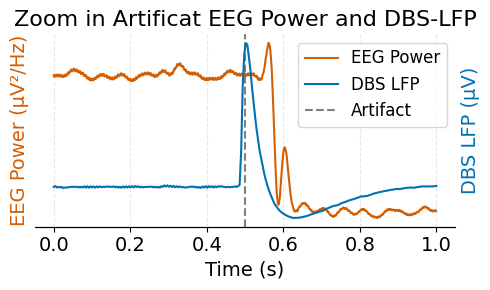

In [21]:
fig, ax1 = plt.subplots(figsize=(5, 3))

# EEG power on primary y-axis
eeg_line, = ax1.plot(eeg_times, eeg_power_artifact, color='#D55E00', label='EEG Power')
ax1.set_ylabel('EEG Power (μV²/Hz)', fontsize=14, color='#D55E00')
ax1.set_xlabel('Time (s)', fontsize=14)
ax1.set_title(f'Zoom in Artificat EEG Power and DBS-LFP', fontsize=16)

# DBS LFP on secondary y-axis
ax2 = ax1.twinx()
dbs_line, = ax2.plot(dbs_times, dbs_artifact, color='#0072B2', label='DBS LFP')
ax2.set_ylabel('DBS LFP (μV)', fontsize=14, color='#0072B2')
ax2.set_yticks([])

# Vertical line for sync artifact
artifact_line = ax1.axvline(0.5, color='grey', linestyle='--', label='Artifact')

# Styling: remove spines and y-ticks (left)
for ax in [ax1, ax2]:
    for spine in ['top', 'right', 'left']:
        ax.spines[spine].set_visible(False)

ax1.set_yticks([])
ax1.grid(True, linestyle="--", alpha=0.3)

# xticks fontsize 14
ax1.tick_params(axis='x', labelsize=14)

# Legend combining both axes
lines = [eeg_line, dbs_line, artifact_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, fontsize=12, loc='upper right')

plt.tight_layout()

# save plot as pdf in outputs/plots
plt.savefig(f"outputs/plots/fig1_eeg_dbs_artifact.pdf")

plt.show()

### 5. Crop and align time series

In [22]:
# back to original data
from source.synchronizer import cut_data_at_sync, synchronize_data
cropped_eeg, cropped_dbs = cut_data_at_sync(eeg_data_ch_selected, dbs_data, dbs_peak_idx, eeg_sync_idx)

---
Cropped EEG length: 4.384125 minutes
---
Cropped DBS length: 2.5465333333333335 minutes


---
Overlay plot saved to outputs/plots/eeg_dbs_overlay_P4-2002_baseline_20250822_093804.png
---
Please close the overlay plot to continue.


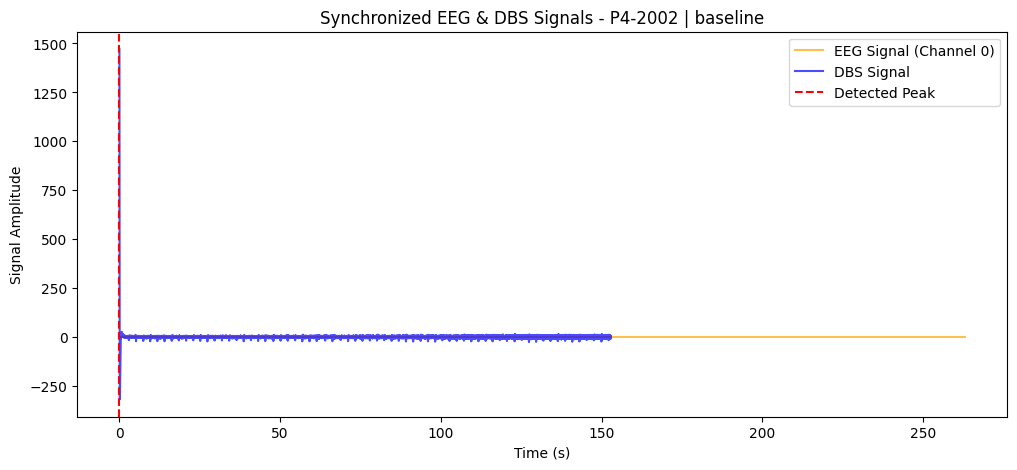

In [23]:
synchonized_eeg, synchronized_dbs = synchronize_data(cropped_eeg, cropped_dbs, resample_data=True, save_dir="outputs/plots", sub_id=sub_id, block=block)

In [24]:
# list eeg channel names

eeg_data_ch_selected.ch_names

['Cz', 'Fz', 'POz']

In [25]:
# plot the synchronized data up until 120 seconds

synchonized_eeg_1ch_cropped = synchonized_eeg.get_data()[2][0:120*250]
synced_eeg_times = np.arange(len(synchonized_eeg_1ch_cropped)) / 250
synchonized_dbs_cropped = synchronized_dbs["TimeDomainData"][0:120*250]


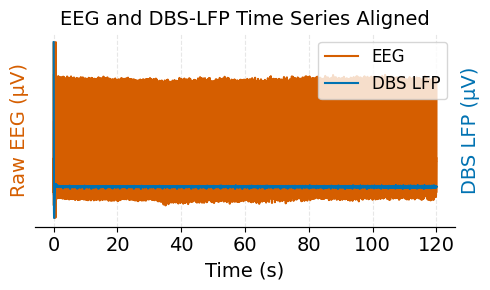

In [26]:
fig, ax1 = plt.subplots(figsize=(5, 3))

# EEG signal
eeg_line, = ax1.plot(synced_eeg_times, synchonized_eeg_1ch_cropped, color='#D55E00', label='EEG')
ax1.set_ylabel('Raw EEG (μV)', fontsize=14, color='#D55E00')
ax1.set_xlabel('Time (s)', fontsize=14)
ax1.set_title(f'EEG and DBS-LFP Time Series Aligned', fontsize=14)

# DBS signal
ax2 = ax1.twinx()
dbs_line, = ax2.plot(synced_eeg_times, synchonized_dbs_cropped, color='#0072B2', label='DBS LFP')
ax2.set_ylabel('DBS LFP (μV)', fontsize=14, color='#0072B2')

# Clean spines and ticks
for ax in [ax1, ax2]:
    for spine in ['top', 'right', 'left']:
        ax.spines[spine].set_visible(False)
    ax.set_yticks([])

ax1.grid(True, linestyle="--", alpha=0.3)

# xticks fontsize 14
ax1.tick_params(axis='x', labelsize=14)

# Combine legends
lines = [eeg_line, dbs_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right', fontsize=12)

plt.tight_layout()

# save plot as pdf in outputs/plots
plt.savefig(f"outputs/plots/fig1_eeg_dbs_final.pdf")
plt.show()